In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from imutils import build_montages

### Konstanty

In [2]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUMBER_OF_PICS = 16

### Moje funkce

In [3]:
# načte obrázek a předzpracuje ho
def load_image(img_path):
    # načtení obrázku
    img = cv2.imread(img_path)
    # převede obrázek z BGR na RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # upraví velikost obrázku 
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return img

# funkce pro přidání "klasifikačního proužku
def add_prob_bar(img, predictions):
    fan_percents = 0
    spider_percents = 0   
    preds = decode_predictions(predictions)
    # for loop, který zjistí, kolik procent je predikce pro každou třídu
    for pred in preds:
        for line in pred:
            if(line[1] == 'spider_web'):
                spider_percents = math.floor(IMG_WIDTH*line[2])

            if(line[1] == 'electric_fan'):
                fan_percents = math.floor(IMG_WIDTH*line[2])
    # vložení proužku do obrázku 
    upper_bound = fan_percents+spider_percents
    img[0:10, 0:fan_percents] = [0, 255, 0]
    img[0:10, fan_percents:upper_bound] = [255, 0, 0]
    return img
        

# tato funkce je ze Stack Overflow
# slouží k vložení zvýrazněného textu do obrázku
# zdroj:
# https://stackoverflow.com/questions/60674501/how-to-make-black-background-in-cv2-puttext-with-python-opencv
def draw_text(img, text,
          font=cv2.FONT_HERSHEY_PLAIN,
          pos=(0, 0),
          font_scale=1,
          font_thickness=1,
          text_color=(0, 0, 0),
          text_color_bg=(0, 0, 0)
          ):

    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(img, pos, (x + text_w, y + text_h), text_color_bg, -1)
    cv2.putText(img, text, (x, y + text_h + font_scale - 1), font, font_scale, text_color, font_thickness)

    return text_size

### Načtení ResNet a klasifikace obrázků

In [4]:
model = ResNet50(weights='imagenet')

In [5]:
spider_net_path = './pavucina.jpg'
fan_img_path = './vetrak.jpg'

In [6]:
# načtení obrázků
spider_net_img = load_image(spider_net_path)
fan_img = load_image(fan_img_path) 

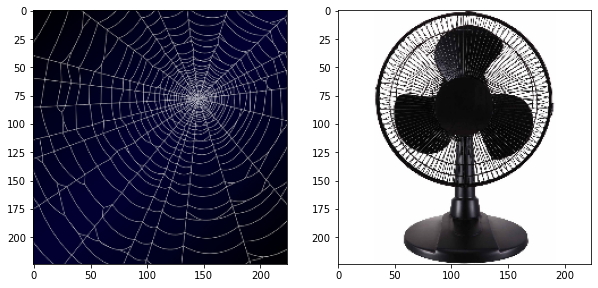

In [7]:
# zobrazení obrázků
f, axarr = plt.subplots(1, 2, figsize=(10,10))
axarr[0].imshow(spider_net_img)
axarr[1].imshow(fan_img)

#### Klasifikace větráku

In [8]:
x = np.expand_dims(fan_img, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
print('Predikce:', decode_predictions(preds, top=1)[0])

2023-01-08 22:08:11.105734: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-08 22:08:11.105883: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Predikce: [('n03271574', 'electric_fan', 0.99962056)]


Síť správně klasifikovala větrák

#### Klasifikace pavučiny

In [9]:
y = np.expand_dims(spider_net_img, axis=0)
y = preprocess_input(y)
preds_2 = model.predict(y)
print('Predikce:', decode_predictions(preds_2, top=1)[0])

Predikce: [('n04275548', 'spider_web', 0.99459165)]


Síť správně klasifikovala pavučinu

### Prolnutí obrázků a predikce na prolnutých obrázcích

In [10]:
blend_arr = []
j = 0.2 / (NUMBER_OF_PICS-1)

for i in range(0, NUMBER_OF_PICS+1):
    # prolnutí obrázků pavučiny a větráku
    blended = cv2.addWeighted(spider_net_img, 0.4 - j*i, fan_img, 0.2 + j*i, 0.0)
    # predikce sítě na prolnutém obrázku
    y = np.expand_dims(blended, axis=0)
    y = preprocess_input(y)
    pred = model.predict(y)
    # tato část napíše predikci sítě do pravého spodního rohu obrázku 
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(blended, decode_predictions(pred, top=1)[0][0][1], (80,220), font, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
    # vložení klasifikačního proužku do obrázku
    blended = add_prob_bar(blended, pred)
    # napíše váhu větráku na obrázku ve zvýrazněném textu
    draw_text(blended, str((0.2 + j*i)), font_scale=1, pos=(0, 10), text_color_bg=(255,255,153))
    blend_arr.append(blended)

### Zobrazení všech obrázků jednotlivě

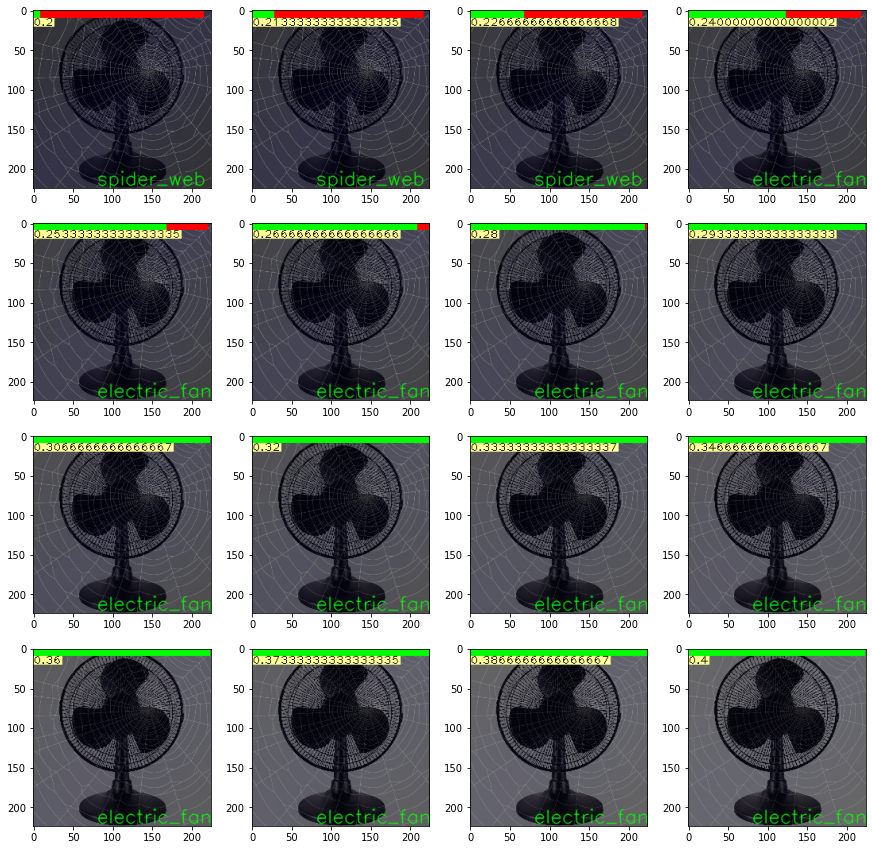

In [11]:
f, axarr = plt.subplots(4,4, figsize=(15, 15))

index = 0

for i in range(0,4):
    for j in range(0, 4):
        axarr[i,j].imshow(blend_arr[index+i+j])
        if(j == 3):
            index += j

### Vytvoření a zobrazení montáže

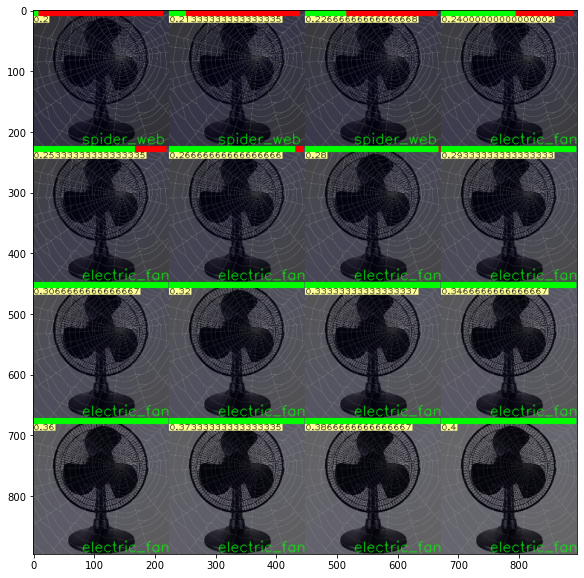

In [12]:
montages = build_montages(blend_arr, (IMG_WIDTH, IMG_HEIGHT), (4, 4))
montage = montages[0]

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.imshow(montage)
plt.show()